# Geospatial Image Classification with Deep Learning - PyTorch
## End‑to‑End Satellite Image Analysis using CNNs and Vision Transformers

## Table of Contents

[The Dataset](#The-Dataset)

[The Required Libraries and Environment Settings](#The-Required-Libraries-and-Environment-Settings)
   - [TensorFlow Environment Settings](#TensorFlow-Environment-Settings)
   - [The Required Libraries](#The-Required-Libraries)
   - [Set Random Seed for Reproducibility](#Set-Random-Seed-for-Reproducibility)
   - [Check GPU Availability](#Check-GPU-Availability)
   - [Define Data Folder Path](#Define-Data-Folder-Path)

[Model Hyperparameters](#Model-Hyperparameters)

[Create Image Data Generator for Data Augmentation](#Create-Image-Data-Generator-for-Data-Augmentation)

[Create Training and Validation Generators](#Create-Training-and-Validation-Generators)

[Model Definition](#Model-Definition)

[Model Compilation](#Model-Compilation)

[Model Training](#Model-Training)

[Model Evaluation](#Model-Evaluation)
   - [Training and Validation Curves](#Training-and-Validation-Curves)    


## The Dataset

The dataset contains 6,000 color satellite images, each resized to 64×64 pixels and labeled for a binary land‑use classification task. Every image belongs to one of two categories:

- ``class_0_non_agri``: regions without agricultural activity (e.g., forests, urban regions, water bodies, barren land).

- ``class_1_agri``: areas showing agricultural structures such as crop fields or structured farmland.

The images are evenly distributed across both classes and exhibit natural variability in geographic context. This diversity helps the model generalize to different environmental conditions and reduces overfitting to specific visual patterns.

All images are RGB and share the same spatial resolution and are preprocessed into a consistent format suitable for convolutional neural networks. The dataset provides a solid foundation for training and evaluating models aimed at automated agricultural land‑use detection.

## The Required Libraries and Environment Settings

### The Required Libraries

In [7]:
import warnings
warnings.filterwarnings('ignore')

In [8]:
import json
import os
import sys
import time
import shutil
import random
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt

In [9]:
import torch
import torch.nn as nn
import torch.optim as optim

from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split

from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    accuracy_score
)

### Set Random Seed for Reproducibility  

In [15]:
def set_seed(seed = 62):
    # Python random
    random.seed(seed)

    # NumPy
    np.random.seed(seed)

    # PyTorch CPU
    torch.manual_seed(seed)

    # PyTorch CUDA
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

    # Ensure deterministic behavior
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

    print(f"Random seed set to {seed}")

In [17]:
SEED = 62
set_seed(SEED)

Random seed set to 62


It is important to define `worker_init_fn()` because every DataLoader worker in PyTorch runs in its own separate process, each with its own independent random‑number generators. If we don’t explicitly re‑seed those workers, they all inherit the same RNG (Random Number Generator) state, which leads to nondeterministic behavior in shuffling, batching, and data augmentation. By giving each worker a unique, reproducible seed, we ensure that every run of your training pipeline produces the same sequence of batches and the same random transformations. This closes one of the biggest gaps in PyTorch reproducibility and brings its behavior much closer to the consistency we’re used to from TensorFlow’s more tightly controlled data pipeline.

In [19]:
def worker_init_fn(worker_id):
    """Ensure each DataLoader worker has a unique, reproducible seed."""
    worker_seed = SEED + worker_id
    np.random.seed(worker_seed)
    random.seed(worker_seed)
    torch.manual_seed(worker_seed)

### Check GPU Availability

In [20]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

if device.type == "cuda":
    print("GPU:", torch.cuda.get_device_name(0))
    print("CUDA version:", torch.version.cuda)
    print("cuDNN version:", torch.backends.cudnn.version())

Using device: cpu


### Define Data Folder Path

In [21]:
data_path = os.path.join(".", "data") 
print("Data folder path:", data_path)

Data folder path: .\data


## Model Hyperparameters

Use a batch size that evenly divides both the number of validation samples and the number of training samples to prevent partial batches.



In [ ]:
# Model hyperparameters
img_w, img_h = 64, 64
n_channels = 3     # Number of image channels (3 for RGB)
n_classes = 2      # Number of output classes

batch_size = 120
lr = 1e-3           # Learning rate
n_epochs = 20       # Number of epochs

model_name = "pytorch_model"

## Create Image Data Generator for Data Augmentation

In [ ]:
train_transform = transforms.Compose([
    # Resize every input image to the exact width and height
    transforms.Resize((img_w, img_h)),
    transforms.RandomRotation(25),
    transforms.RandomAffine(
        degrees= 0,
        translate= (0.2, 0.2),   # width_shift_range & height_shift_range
        shear= 20,               # shear_range
        scale= (0.8, 1.2)        # zoom_range
    ),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    # Convert to [0,1] automatically
    transforms.ToTensor(),       
    transforms.Normalize([0.485, 0.456, 0.406], 
                         [0.229, 0.224, 0.225]),
])

In [ ]:
val_transform = transforms.Compose([
    transforms.Resize((img_w, img_h)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

## Create Training and Validation Generators

In [20]:
train_generator = datagen.flow_from_directory(
    data_path,
    target_size= (img_w, img_h),
    batch_size= batch_size,
    class_mode= "binary",  # "categorical" for multi-class
    subset= "training",
    shuffle= True,
    seed= SEED,
)

val_generator = datagen.flow_from_directory(
    data_path,
    target_size= (img_w, img_h),
    batch_size= batch_size,
    class_mode= "binary",  # "categorical" for multi-class
    subset= "validation",
    shuffle= False,
    seed= SEED,
)


Found 4800 images belonging to 2 classes.
Found 1200 images belonging to 2 classes.


> Why ``shuffle=True`` for training but ``shuffle=False`` for validation

Shuffling is enabled for the training generator because the model should see 
the data in a different order in each epoch to improve generalization and to reduce overfitting, while the validation generator keeps ``shuffle=False`` so evaluation remains stable and deterministic. Even with a fixed seed, shuffling the validation set is still discouraged because the goal of validation is stable, repeatable evaluation. A seed only guarantees that the shuffle order is the same each run, but the order would still change every epoch.

For ``flow_from_directory``, the default value of ``shuffle`` is ``True``.

## Model Definition

In [21]:
def build_cnn(input_shape, num_classes= 1):
    model = Sequential([
        # --- Convolution Block 1 ---
        Conv2D(32, 
               (5, 5), 
               activation= "relu", 
               padding= "same",
               strides= (1, 1), 
               kernel_initializer= HeUniform(),
               input_shape= input_shape),
        MaxPooling2D((2, 2)),
        BatchNormalization(),

        # --- Convolution Block 2 ---
        Conv2D(64, 
               (5, 5), 
               activation="relu", 
               padding= "same",
               strides= (1, 1), 
               kernel_initializer= HeUniform()),
        MaxPooling2D((2, 2)),
        BatchNormalization(),

        # --- Convolution Block 3 ---
        Conv2D(128, 
               (5, 5), 
               activation= "relu", 
               padding= "same",
               strides= (1, 1), 
               kernel_initializer= HeUniform()),
        MaxPooling2D((2, 2)),
        BatchNormalization(),

        # --- Convolution Block 4 ---
        Conv2D(256, 
               (5, 5), 
               activation= "relu", 
               padding= "same",
               strides= (1, 1), 
               kernel_initializer= HeUniform()),
        MaxPooling2D((2, 2)),
        BatchNormalization(),

        # --- Convolution Block 5 ---
        Conv2D(512, 
               (5, 5), 
               activation= "relu", 
               padding= "same",
               strides= (1, 1), 
               kernel_initializer= HeUniform()),
        MaxPooling2D((2, 2)),
        BatchNormalization(),

        # --- Convolution Block 6 ---
        Conv2D(1024, 
               (5, 5), 
               activation= "relu", 
               padding= "same",
               strides= (1, 1), 
               kernel_initializer= HeUniform()),
        MaxPooling2D((2, 2)),
        BatchNormalization(),

        # --- Global Pooling ---
        GlobalAveragePooling2D(),

        # --- Dense Block 1 ---
        Dense(64, 
              activation= "relu", 
              kernel_initializer= HeUniform()),
        BatchNormalization(),
        Dropout(0.4),

        Dense(128, 
              activation= "relu", 
              kernel_initializer= HeUniform()),
        BatchNormalization(),
        Dropout(0.4),

        Dense(256, 
              activation= "relu", 
              kernel_initializer= HeUniform()),
        BatchNormalization(),
        Dropout(0.4),

        # --- Dense Block 2 ---
        Dense(512, 
              activation= "relu", 
              kernel_initializer= HeUniform()),
        BatchNormalization(),
        Dropout(0.4),

        Dense(1024, 
              activation= "relu", 
              kernel_initializer= HeUniform()),
        BatchNormalization(),
        Dropout(0.4),

        Dense(2048, 
              activation= "relu", 
              kernel_initializer=HeUniform()),
        BatchNormalization(),
        Dropout(0.4),

        # --- Output Layer ---
        Dense(num_classes, activation="sigmoid")
    ])

    return model

## Model Compilation

In [22]:
# Build the model
model = build_cnn(
    input_shape= (img_w, img_h, n_channels),
    num_classes= 1
)


In [23]:
# Compile the model
model.compile(
    optimizer= Adam(learning_rate= lr),
    loss= "binary_crossentropy",
    metrics= ["accuracy"]
)

# Display model summary
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 64, 64, 32)     │         2,432 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 32, 32, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 32, 32, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 32, 32, 64)     │        51,264 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 16, 16, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 16, 16, 128)    │       204,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 8, 8, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 8, 8, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 8, 8, 256)      │       819,456 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 4, 4, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 4, 4, 256)      │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 4, 4, 512)      │     3,277,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 2, 2, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 2, 2, 512)      │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 2, 2, 1024)     │    13,108,224 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 1, 1, 1024)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 1, 1, 1024)     │         4,096 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1024)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │        65,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │             

 Total params: 20,352,897 (77.64 MB)

 Trainable params: 20,340,801 (77.59 MB)

 Non-trainable params: 12,096 (47.25 KB)

>**Layers with no parameters** 

- MaxPooling

- GlobalAveragePooling

- Dropout

- Activation layers

In [24]:
total_layers = len(model.layers)

print("Total layers:", len(model.layers))

Total layers: 38


## Training Setup

In [25]:
# Callbacks
early_stop = EarlyStopping(
    monitor= "val_loss",
    patience= 8,
    restore_best_weights= True
)

reduce_lr = ReduceLROnPlateau(
    monitor= "val_loss",
    factor= 0.2,
    patience= 5,
    min_lr= 1e-6,
)

checkpoint = ModelCheckpoint(
    filepath= model_name + ".keras",
    monitor= "val_loss",
    verbose= 0,
    save_best_only= True,
    mode= "min",    # for minimizing val_loss
)

callbacks = [early_stop, reduce_lr, checkpoint]

Where EarlyStopping decides when to stop, ReduceLROnPlateau decides how fast the model should keep learning.

> What ``EarlyStopping`` does

- It monitors ``val_loss`` every epoch. If ``val_loss`` does not improve for patience consecutive epochs (``patience=8``), training stops early. It restores the best weights seen during training (``restore_best_weights=True``), not the weights from the final epoch.

<br><br>

> What ``ReduceLROnPlateau`` does

- ``ReduceLROnPlateau`` is the adaptive learning‑rate  controller. It watches a metric — in our case "``val_loss``" — and if that metric stops improving for a certain number of epochs (``patience=5``), it reduces the learning rate by a factor (``factor=0.2``). \
So with our settings:
  - If validation loss does not improve for 4 epochs then the learning rate becomes
  $$
  \text{new\_lr} = 0.2 \cdot \text{old\_lr}
  $$
  It keeps doing this until it reaches the minimum allowed learning rate (``min_lr=1e-6``).

<br><br>

> What ``ModelCheckpoint`` does

- ModelCheckpoint is our automatic model saver.
- It monitors the metric ``val_loss``. Every time ``val_loss`` reaches a new minimum, it saves the model to disk. It overwrites the previous checkpoint so we always keep the best model, not the last one.


## Model Training

In [26]:
# Steps per epoch 
steps_per_epoch = train_generator.samples // batch_size
validation_steps = val_generator.samples // batch_size

In [16]:
# ====================== Training Overview ======================

print(
    f"\n"
    f"================ Training Hyperparameters ================\n"
    f"  Device:                   {device}\n"
    f"  n_classes (train):        {train_generator.num_classes}\n"
    f"  n_classes (validation):   {val_generator.num_classes}\n"
    f"  Image Size:               ({img_w}, {img_h})\n"
    f"  n_channels:               {n_channels}\n"
    f"  batch_size:               {batch_size}\n"
    f"  steps_per_epoch:          {steps_per_epoch}\n"
    f"  validation_steps:         {validation_steps}\n"
    f"  n_epochs:                 {n_epochs}\n"
    f"  learning_rate:            {lr}\n"
    f"=========================================================="
)



================ Training Hyperparameters ================
  Device:                   cpu
  n_classes (train):        2
  n_classes (validation):   2
  Image Size:               (64, 64)
  n_channels:               3
  batch_size:               120
  steps_per_epoch:          40
  validation_steps:         10
  n_epochs:                 20
  learning_rate:            0.001


In [17]:
%%time

# ==== Fit Model on Training Data ====

history = model.fit(
    train_generator,
    epochs= n_epochs,
    steps_per_epoch= steps_per_epoch,
    validation_data= val_generator,
    validation_steps= validation_steps,
    callbacks= [early_stop, reduce_lr, checkpoint],
    verbose= 1,
)

Epoch 1/20
40/40 ━━━━━━━━━━━━━━━━━━━━ 145s 3s/step - accuracy: 0.8725 - loss: 0.3700 - val_accuracy: 0.5017 - val_loss: 88.6346 - learning_rate: 0.0010
Epoch 2/20
40/40 ━━━━━━━━━━━━━━━━━━━━ 135s 3s/step - accuracy: 0.9596 - loss: 0.1438 - val_accuracy: 0.4383 - val_loss: 14.7601 - learning_rate: 0.0010
Epoch 3/20
40/40 ━━━━━━━━━━━━━━━━━━━━ 139s 3s/step - accuracy: 0.9704 - loss: 0.1070 - val_accuracy: 0.5367 - val_loss: 2.8220 - learning_rate: 0.0010
Epoch 4/20
40/40 ━━━━━━━━━━━━━━━━━━━━ 139s 3s/step - accuracy: 0.9771 - loss: 0.0805 - val_accuracy: 0.6650 - val_loss: 1.5079 - learning_rate: 0.0010
Epoch 5/20
40/40 ━━━━━━━━━━━━━━━━━━━━ 140s 3s/step - accuracy: 0.9773 - loss: 0.0787 - val_accuracy: 0.8092 - val_loss: 0.4917 - learning_rate: 0.0010
Epoch 6/20
40/40 ━━━━━━━━━━━━━━━━━━━━ 138s 3s/step - accuracy: 0.9829 - loss: 0.0562 - val_accuracy: 0.8567 - val_loss: 0.3811 - learning_rate: 0.0010
Epoch 7/20
40/40 ━━━━━━━━━━━━━━━━━━━━ 143s 4s/step - accuracy: 0.9783 - loss: 0.0653 - val_a

In [ ]:
# Save training history to a JSON file
with open("training_history.json", "w") as f:
    json.dump(history.history, f)

## Model Evaluation

In [27]:
def evaluate_model(model, generator):
    """
    Evaluate a trained model on a given dataset generator.
    Computes accuracy, confusion matrix, and classification report.
    """

    # --- Manual evaluation for detailed metrics ---
    steps = int(np.ceil(generator.samples / generator.batch_size))

    all_preds = []
    all_labels = []

    for _ in range(steps):
        images, labels = next(generator)
        probs = model.predict(images, verbose=0)
        preds = (probs > 0.5).astype(int).flatten()

        all_preds.extend(preds)
        all_labels.extend(labels)

    # --- Detailed metrics ---
    print("\n=== Detailed Metrics ===")
    print(f"Accuracy: {accuracy_score(all_labels, all_preds):.4f}")

    print("\nConfusion Matrix:")
    print(confusion_matrix(all_labels, all_preds))

    print("\nClassification Report:")
    print(classification_report(all_labels, all_preds, digits=4))


In [28]:
model = load_model("tf_model.keras")

evaluate_model(model, val_generator)


=== Detailed Metrics ===
Accuracy: 0.9917

Confusion Matrix:
[[592   8]
 [  2 598]]

Classification Report:
              precision    recall  f1-score   support

         0.0     0.9966    0.9867    0.9916       600
         1.0     0.9868    0.9967    0.9917       600

    accuracy                         0.9917      1200
   macro avg     0.9917    0.9917    0.9917      1200
weighted avg     0.9917    0.9917    0.9917      1200



### Training and Validation Curves

In [14]:
with open("training_history.json", "r") as f:
    hist_data = json.load(f)

class DummyHistory:
    def __init__(self, history_dict):
        self.history = history_dict

history_data = DummyHistory(hist_data)

In [67]:
def plot_training_history(history_data):
    """Plot training and validation accuracy/loss curves with best epoch markers."""

    # Extract metrics
    acc = history_data.history.get("accuracy")
    val_acc = history_data.history.get("val_accuracy")
    loss = history_data.history.get("loss")
    val_loss = history_data.history.get("val_loss")

    epochs = range(1, len(acc) + 1)

    # Best validation accuracy epoch
    best_acc_epoch = val_acc.index(max(val_acc)) + 1

    # Minimum validation loss epoch
    best_loss_epoch = val_loss.index(min(val_loss)) + 1

    plt.figure(figsize=(7, 7))

    # =====================
    # --- Accuracy plot ---
    #----------------------
    plt.subplot(2, 1, 1)
    plt.plot(epochs, acc, label="Training Accuracy", color="green")
    plt.plot(epochs, val_acc, label="Validation Accuracy", color="darkred")

    # The point for best validation accuracy
    plt.scatter(
        best_acc_epoch,
        val_acc[best_acc_epoch - 1],
        color="darkred",
        s= 50,          # point size
        zorder= 5
        )

    plt.text(
        best_acc_epoch,
        # Shift downward
        val_acc[best_acc_epoch - 1] - 0.08,   
        f"Max Val Acc\nEpoch: {best_acc_epoch}",
        color= "darkred",
        fontsize= 7,
        # Center horizontally under the point
        ha= "center"   
    )

    plt.title("Accuracy Over Epochs")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.grid(True, alpha= 0.3)

    # =================
    # --- Loss plot ---
    #------------------
    plt.subplot(2, 1, 2)
    plt.plot(epochs, 
             loss, 
             label= "Training Loss", 
             color= "green")
    plt.plot(epochs, 
             val_loss, 
             label= "Validation Loss", 
             color= "darkred")

    # The point for minimum validation loss
    plt.scatter(
        best_loss_epoch,
        val_loss[best_loss_epoch - 1],
        color= "darkred",
        s= 50,          # point size
        zorder= 5
        )
    plt.text(best_loss_epoch, 
             # Adjust downward offset as needed
             val_loss[best_loss_epoch - 1] + 12,
             f"Min Val Loss\n Epoch: {best_loss_epoch}",
             color= "darkred", 
             fontsize= 7,
             ha= "center",
             va= "top")

    plt.title("Loss Over Epochs")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
    plt.grid(True, alpha= 0.3)

    plt.tight_layout()
    plt.subplots_adjust(hspace= 0.5)
    plt.show()


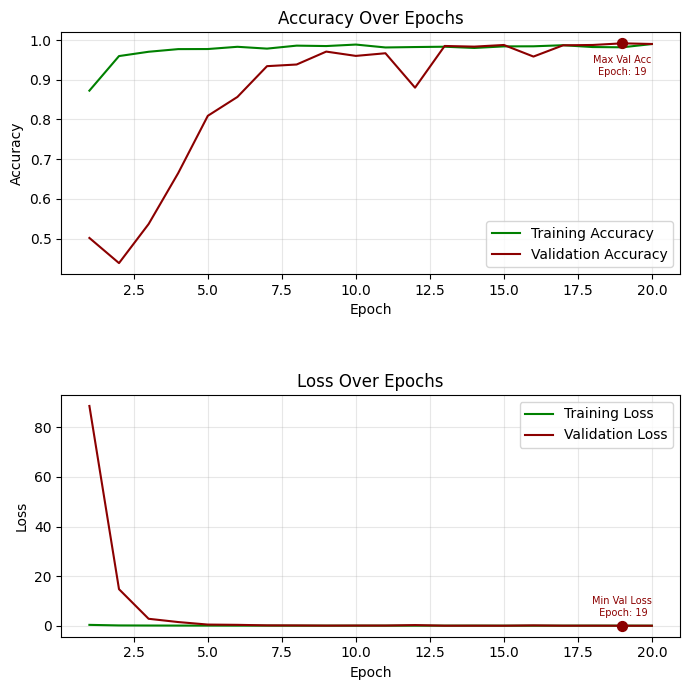

In [68]:
plot_training_history(history_data)